# Gene-Prediction-in-Metagenomics-Fragments_v6
Written by: Vignesh Ravindranath, Shawn Huang

    This project was based on the 2008 paper 'Gene prediction in metagenomic fragments: A large scale machine learning approach' by Hoff et at (see link below). The purpose of the project is to gain a deeper understanding of machine learning approaches and bioinformatics concepts.
    The project consists of three main steps:
    1) Feature engineering/extraction
    2) Linear Discriminant training on high-dimentional features
    3) Binary classification neural network for coding/noncoding gene prediction
    
    In the first step, features such as monocodon (tricodon) usage, dicodon (hexcodon) usage, translation initiation sites (TIS), and GC content must be extracted from prokaryotic genomes. Monocodon and dicodon usage refer to the frequence of codons and dicodons (6 base pairs) in coding and noncoding regions. Coding proteins often have a TIS upstream of the start codon. These TIS patterns are extracted by comparing up and downstream regions for positive TIS candidates (true start codons in coding sequences) to negative TIS candidates (in-frame start codons within coding sequences). Lastly, it is well known that the GC content between coding and noncoding regions vary. 
    In the second step, linear discriminants are derived to reduce the dimensionality of the extracted features. The individual features (excluding GC content) are taken as multivariate linear regression problems and the Normal Equation is utilized to compute the weights (coefficient) matrix for each feature. 
    In the last step, a neural network is trained on fragmented data.
    
    
    Summary of features:
    x1 - tricodon       - (n,64) table --reduced to a weights matrix of (64,1)
    x2 - hexcodon       - (n,4096) table --reduced to a weights matrix of (4096,1)
    x3 - positive TIS   - (n,58,64 == n,3712) table --reduced to a weights matrix of (3712,1)
    x4 - negative TIS   - (m,58,64 == m,3712) table --reduced to a weights matrix of (3712,1)
    x5 - complete seq   - 1 if fragment contains a complete gene, else 0
    x6 - incomplete seq - 0 if fragment contains a complete gene, else 1
    x7 - GC content     - (n,1) column

Reference Gene Prediciton Paper (Hoff et al.):
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-217

Genbank link (A fulgidus - test prokaryotic genome): 
- https://www.ncbi.nlm.nih.gov/nuccore/NC_000917

Biopython references
- http://biopython.org/DIST/docs/tutorial/Tutorial.html
- https://biopython.org/wiki/Intergenic_regions
- https://biopython.org/docs/dev/api/Bio.SeqFeature.html

In [1]:
import re
import numpy as np
import pandas as pd
import textwrap
import itertools

import sys
import Bio
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation

import pickle

### SEQ_RECORDS FORMAT - Genbank format
    ~~type: CDS~~
    location: [254:758](+)
    qualifiers:
        ~~Key: codon_start, Value: ['1']~~
        ~~Key: db_xref, Value: ['GeneID:1485667']~~
        ~~Key: gene, Value: ['cas4']~~
        ~~Key: inference, Value: ['value]~~
        Key: locus_tag, Value: ['AF_RS12285']
        ~~Key: note, Value: ['note']~~
        ~~Key: old_locus_tag, Value: ['AF2436', 'AF_2436']~~
        ~~Key: product, Value: ['CRISPR-associated protein Cas4']~~
        ~~Key: protein_id, Value: ['WP_010879923.1']~~
        ~~Key: transl_table, Value: ['11']~~
        Key: translation, Value: ['SEQ']

### INTERGENIC/CODING/NONCODING RECORDS FORMAT - SeqRecord object
    ID: NC_000000                        | ID (coding=AF_RS#####; noncoding=NC_0#####)
    ~~Name: <unknown name>~~             | NA
    Description: NC_000917 759-765 1     | Name start-end +1/-1 strand
    ~~Number of features: 0~~            | NA
    Seq('TCGGGCC', IUPACAmbiguousDNA())  | Sequence

In [2]:
class ProkaryoteData:
    
    def __init__(self, genbank_path, fasta_path):        
        # Consts
        self.__GENBANK_PATH = genbank_path
        self.__FASTA_PATH = fasta_path
        
        self.__START_CODONS = ['ATG','CTG','GTG','TTG']
        self.__STOP_CODONS = ['TAG','TGA','TAA']
        self.__TRICODON_IDX_DICT = self.__populate_codon_idx_dict(nbases=3)
        self.__HEXCODON_IDX_DICT = self.__populate_codon_idx_dict(nbases=6)
        
        self.coding_dna = self.__get_sequence(self.__FASTA_PATH)
        self.template_dna = self.coding_dna.reverse_complement()
        
        # Records - SeqRecord with all information about coding, noncoding, intergenic regions
        self.__coding_records = []     # ORF (start-stop) protein coding sequences
        self.__noncoding_records = []  # ORF (start-stop) noncoding sequences
        self.__intergenic_records = [] # full noncoding sequences
        self.l_min = sys.maxsize       # smallest coding sequence length
        
        self.TisCand = []
        
        # Features
        self.__info = []   # -> df (y (1,-1), gene tag, start, end, length)
        self.__tri = []    # monocodon usage (list of codon dictionaries nx64)            -> df
        self.__hex = []    # dicodon usage (list of codon dictionaries nx4096)            -> df
        self.__TisPos = [] # TIS positive (list of position-codon dictionaries (n,3712))  -> np.array
        self.__TisNeg = [] # TIS negative (list of position-codon dictionaries (m,3712))  -> np.array
        self.__GC = []     # GC content (list (n,1))                                      -> df

        
    # GETTERS
    def get_records(self):
        return self.__coding_records, self.__noncoding_records, self.__intergenic_records        
    
    def get_codon_features(self):
        # convert to df
        columns = ['y','label','start','end','len'] 
        info_df = pd.DataFrame(self.__info, columns=columns).reset_index(drop=True)
        x1_df = pd.DataFrame(self.__tri).reset_index(drop=True)
        x2_df = pd.DataFrame(self.__hex).reset_index(drop=True)
        x7_df = pd.DataFrame(self.__GC).reset_index(drop=True)
        
        return info_df, x1_df, x2_df, x7_df
    
    def get_tis_features(self):
        TisPos_reshaped = np.array(self.__TisPos).reshape(len(self.__TisPos), -1)
        TisNeg_reshaped = np.array(self.__TisNeg).reshape(len(self.__TisNeg), -1)
        
        return TisPos_reshaped, TisNeg_reshaped

    # PUBLIC METHODS
    def extract_codon_features(self):
        # populate info, tri, hex, and GC variables (df)
        self.__positive_codons(self.__GENBANK_PATH)
        self.__negative_codons(self.__GENBANK_PATH)
        
        # convert to df
        columns = ['y','label','start','end','len'] 
        info_df = pd.DataFrame(self.__info, columns=columns).reset_index(drop=True)
        x1_df = pd.DataFrame(self.__tri).reset_index(drop=True)
        x2_df = pd.DataFrame(self.__hex).reset_index(drop=True)
        x7_df = pd.DataFrame(self.__GC).reset_index(drop=True)
        
        return info_df, x1_df, x2_df, x7_df

    def extract_tis_features(self):
        # populate TisPos, TisNeg variables (np.array)
        self.__tis_features(self.__GENBANK_PATH)
        
        TisPos_reshaped = np.array(self.__TisPos).reshape(len(self.__TisPos), -1)
        TisNeg_reshaped = np.array(self.__TisNeg).reshape(len(self.__TisNeg), -1)
        
        return TisPos_reshaped, TisNeg_reshaped


    # PRIVATE METHODS
    '''
    __permutations_with_replacement(n)
    Helper function for __populate_codon_idx_dict. Produces all codon permutations (AAA, AAC,...,TTT)
    Input: n --number of bases = 3
    Output: all 64 codons (String)
    '''
    def __permutations_with_replacement(self, n):
        for i in itertools.product(("A", "C", "G", "T"), repeat=n):
            yield i
    
    '''
    __populate_codon_idx_dict(nbases=3)
    Function to create codon:idx dictionary. Converts codons to integers.
    Input: nbases (default=3 for tricodon dictionary); set nbases=6 for hexcodon dictionary
    Output: returns codon index dictionary
    '''
    def __populate_codon_idx_dict(self, nbases=3):
        codon_idx_dict = {}
        count = 0
        for i in self.__permutations_with_replacement(nbases):
            key = "".join(i) #codon or dicodon sequence
            codon_idx_dict[key] = count
            count += 1
        return codon_idx_dict

    '''
    __get_sequence(fasta_path)
    Input: fasta file (format .fasta)
    Output: returns the coding (sense) dna strand from an in put fasta file
    '''
    def __get_sequence(self, fasta_path):
        coding_dna = ''
        for seq_record in SeqIO.parse(fasta_path, 'fasta'):
            coding_dna = seq_record.seq
        return coding_dna
    
    
    '''
    __codon_parser(seq, nbases)
    Parses dna sequence into a list of codons separated by nbases
    Inputs: seq    --sequence
            nbases --number of bases (set =3 for tricodons or =6 for hexcodons)
    Output: list of tricodons/hexcodons
    
    Ex. Input  - AAATTTGGG
        Output - ['AAA','TTT','GGG'] if nbases=3
               = ['AAATTT']          if nbases=6
    '''
    def __codon_parser(self, seq, nbases):
        codon_seq = [seq[i:i+nbases] for i in range(0,len(seq),3) if (i+nbases)<len(seq)]
        return codon_seq
    
    '''
    __GC_content(seq)
    Input: seq --Bio.Seq.Seq object
    Output: returns GC content of sequence
    '''
    def __GC_content(self, seq):
        # seq = Bio.Seq.Seq object
        return round(float(seq.count("G") + seq.count("C")) / len(seq), 4)
        
        
    ## FOR TRI (x1), HEX (x2), and GC (x7) FEATURES
    '''
    __positive_codons(genbank_file)
    Extracts coding sequences from genbank file (CDS) and stores information in coding_records as SeqRecords.
    Also, extracts positive tricodon, hexcodon, and GC content features from each coding sequences
    '''
    def __positive_codons(self, genbank_path):
        seq_record = next(SeqIO.parse(open(genbank_path), 'genbank'))

        for feature in seq_record.features:
            if feature.type == 'CDS':
                # get relevant sequence information
                mytag = feature.qualifiers['locus_tag'][0]
                mystart = feature.location.start.position
                myend = feature.location.end.position
                mystrand = feature.strand 
                myseq = self.template_dna[mystart:myend] if mystrand==1 else self.coding_dna[::-1][mystart:myend][::-1]
                
                # update min
                if len(myseq) < self.l_min:
                    self.l_min = len(myseq)
                    
                # save information in coding_records
                feature = [SeqFeature(FeatureLocation(mystart,myend,mystrand), type="CDS")]
                record = SeqRecord(myseq, id=mytag, features=feature)
                self.__coding_records.append(record)
                
                # save information into feature variables
                self.__info.append([1, mytag, mystart, myend, len(myseq)])
                
                tricodons = self.__codon_parser(str(myseq),3)
                tframe = [0]*len(self.__TRICODON_IDX_DICT)
                for codon in tricodons:
                    tframe[self.__TRICODON_IDX_DICT[codon]] += 1
                tframe[self.__TRICODON_IDX_DICT[tricodons[-1]]] += 1 # add last codon
                self.__tri.append(tframe)
                
                hexcodons = self.__codon_parser(str(myseq),6)
                hframe = [0]*len(self.__HEXCODON_IDX_DICT)
                for codon in hexcodons:
                    hframe[self.__HEXCODON_IDX_DICT[codon]] += 1
                hframe[self.__HEXCODON_IDX_DICT[hexcodons[-1]]] += 1 # add last codon
                self.__hex.append(hframe)
                
                self.__GC.append(self.__GC_content(myseq))
    
    '''
    __negative_codons(genbank_path)
    Retrieves intergenic regions (sequences between coding sequences) via __get_interregions helper function. 
    Also, extracts negative tricodon, hexcodon, and GC content features from noncoding sequences
    '''
    def __negative_codons(self, genbank_path):
        _, _, self.__intergenic_records = self.__get_interregions(genbank_path)
        
        for seq_record in self.__intergenic_records:
            # get relevant intergenic information
            itr_seq = seq_record.seq
            exact_start = seq_record.features[0].location.start.position
            exact_end = seq_record.features[0].location.end.position
            mytag = seq_record.id            
            mystrand = seq_record.features[0].strand
            
            if len(itr_seq) >= self.l_min:
                # find all start and stop codons in interregion sequence
                all_starts = []
                for s in self.__START_CODONS:
                    matches = re.finditer(s, str(itr_seq))
                    matches_positions = [match.start()+exact_start for match in matches]
                    all_starts.extend(matches_positions)
                all_starts = sorted(all_starts)

                all_stops = []                                      
                for e in self.__STOP_CODONS:
                    matches = re.finditer(e, str(itr_seq))
                    matches_positions = [match.start()+exact_start for match in matches]
                    all_stops.extend(matches_positions)
                all_stops = sorted(all_stops)

                # find largest ORF
                found = False; mystart = None; myend = None;            
                for s in all_starts:
                    for e in all_stops[::-1]:
                        if (e >= s) and ((e-s)%3 == 0):
                            found = True; mystart = s; myend = e;
                            break
                    if found: break

                if mystart==None or myend==None: continue

                myseq = self.template_dna[mystart:myend] if mystrand==1 else self.coding_dna[::-1][mystart:myend][::-1]
                
                # check to see if noncoding ORF is larger than l_min (smallest coding sequence length) 
                if len(myseq) < self.l_min: continue
                
                # save information to in noncoding_records
                feature = [SeqFeature(FeatureLocation(mystart,myend,mystrand), type='interregion')]
                record = SeqRecord(myseq, id=mytag, features=feature)
                self.__noncoding_records.append(record)  

                # save information to feature variables
                self.__info.append([-1, mytag, mystart, myend, len(myseq)])

                tricodons = self.__codon_parser(str(myseq),3)
                tframe = [0]*len(self.__TRICODON_IDX_DICT)
                for codon in tricodons:
                    tframe[self.__TRICODON_IDX_DICT[codon]] += 1
                self.__tri.append(tframe)

                hexcodons = self.__codon_parser(str(myseq),6)
                hframe = [0]*len(self.__HEXCODON_IDX_DICT)
                for codon in hexcodons:
                    hframe[self.__HEXCODON_IDX_DICT[codon]] += 1
                self.__hex.append(hframe)

                # GC content of whole interregion fragment -- bc paper say so
                self.__GC.append(self.__GC_content(itr_seq))

    # Copyright(C) 2009 Iddo Friedberg & Ian MC Fleming
    # Released under Biopython license. http://www.biopython.org/DIST/LICENSE
    # Do not remove this comment
    def __get_interregions(self, genbank_path, intergene_length=1):
        seq_record = next(SeqIO.parse(open(genbank_path), "genbank"))
        cds_list_plus = []
        cds_list_minus = []
        intergenic_records = []

        # Loop over the genome file, get the CDS features on each of the strands
        for feature in seq_record.features:
            if feature.type == 'CDS':
                mystart = feature.location.start.position
                myend = feature.location.end.position
                if feature.strand == -1:
                    cds_list_minus.append((mystart,myend,-1))
                elif feature.strand == 1:
                    cds_list_plus.append((mystart,myend,1))
                else:
                    sys.stderr.write("No strand indicated %d-%d. Assuming +\n" %(mystart, myend))
                    cds_list_plus.append((mystart,myend,1))
        for i,pospair in enumerate(cds_list_plus[1:]):
            # Compare current start position to previous end position
            last_end = cds_list_plus[i][1]
            this_start = pospair[0]
            if this_start - last_end >= 1:
                intergene_seq = seq_record.seq[last_end:this_start]
                strand_string = +1
                name = 'NC_' + str(i).zfill(6)
                feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
                intergenic_records.append(SeqRecord(intergene_seq, id=name, features=feature))
        buffer = i
        for i,pospair in enumerate(cds_list_minus[1:]):
            last_end = cds_list_minus[i][1]
            this_start = pospair[0]
            if this_start - last_end >= 1:
                intergene_seq = seq_record.seq[last_end:this_start]
                strand_string = -1
                name = 'NC_' + str(i+buffer).zfill(6)
                feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
                intergenic_records.append(SeqRecord(intergene_seq, id=name, features=feature))
        return cds_list_plus, cds_list_minus, intergenic_records
    
    
    ## FOR TISPOS (x3) and TISNEG (x4) FEATUERS
    '''
    __tis_features(genbank_path)
    Extracts translation initiation sites (TIS) or 'start codons' from coding sequences. The true start codon for each
    sequence is a positive TIS candidate; the remaining in-frame start codons within the coding sequences are negative
    TIS candidates. 
    A 58x64 (58 positions x 64 codons) table is generated for each TIS candidate (positive and negative).
    '''
    def __tis_features(self, genbank_path):
        seq_record = next(SeqIO.parse(open(genbank_path), 'genbank'))
        for feature in seq_record.features:
            if feature.type == 'CDS':
                # get relevant gene information
                mytag = feature.qualifiers['locus_tag'][0]
                mystart = feature.location.start.position
                myend = feature.location.end.position
                mystrand = feature.strand 
                myseq = self.template_dna[mystart:myend] if mystrand==1 else self.coding_dna[::-1][mystart:myend][::-1]
                
                dna = self.template_dna if int(mystrand)==1 else self.coding_dna     
                
                # find all negative TIS candidates
                TIS_candidates = {'tag':mytag, 'pos':[mystart], 'neg':[]}
                codon_seq = textwrap.wrap(str(myseq), 3)
                for i,codon in enumerate(codon_seq[1:]):
                    if codon in self.__START_CODONS:
                        TIS_candidates['neg'].append((i+1)*3 + mystart)
                self.TisCand.append(TIS_candidates)
                
                # create frame (58x64) for TIS pos
                seq60 = dna[mystart-30:mystart+30]
                frame = [self.__TRICODON_IDX_DICT[seq60[i:i+3]] for i in range(0,len(seq60)-2)]
                '''TIME CONSUMING STEP'''
                self.__TisPos.append(np.eye(64)[np.array(frame)].astype(int))

                # create frames mx(58x64) for TIS neg
                for i,candidate in enumerate(TIS_candidates['neg']):
                    seq60 = dna[candidate-30:candidate+30]
                    frame = [self.__TRICODON_IDX_DICT[seq60[i:i+3]] for i in range(0,len(seq60)-2)]
                    '''TIME CONSUMING STEP'''
                    self.__TisNeg.append(np.eye(64)[np.array(frame)].astype(int))

In [3]:
# extract features or load saved prokaryotic model
import time
BASE_PATH = '/mnt/c/Jupyter/datasets/gene_prediction/'
GENBANK = 'A_fulgidus.gb'
FASTA = 'A_fulgidus.fasta'

save_filename = 'A_fulgidus.prok'
from_saved = True

if not from_saved:
    start_time = time.time()
    prok = ProkaryoteData(BASE_PATH + GENBANK, BASE_PATH + FASTA)
    info_df, x1_df, x2_df, x7_df = prok.extract_codon_features()
    x3_np, x4_np = prok.extract_tis_features()
    print("---- %s seconds" % (round(time.time() - start_time, 4)))
    
    pickle.dump(prok, open(BASE_PATH+save_filename,'wb'))
    print('Saved prokaryote object to file.')
else:
    prok = pickle.load(open(BASE_PATH+save_filename,'rb'))
    
    info_df, x1_df, x2_df, x7_df = prok.get_codon_features()
    x3_np, x4_np = prok.get_tis_features()
    print('Loaded prokaryote object file.')

Loaded prokaryote object file.


In [35]:
TisCands = prok.TisCand
counts = []
c = 0
for TisCand in TisCands:
    counts.append(len(TisCand['neg']))
    c += 1   
print(c)

2473


In [27]:
print(st.mean(counts))
print(max(counts))
print(min(counts))

21.773554387383744
137
0


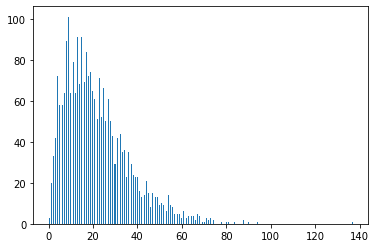

In [30]:
# visualize number of negative TIS candidates per coding sequence
import matplotlib.pyplot as plt

plt.hist(counts, 300)
plt.show()

In [33]:
info_df['len'].describe()

count     3360.000000
mean      1250.357440
std       1821.880973
min         81.000000
25%        423.000000
50%        786.000000
75%       1311.000000
max      38778.000000
Name: len, dtype: float64

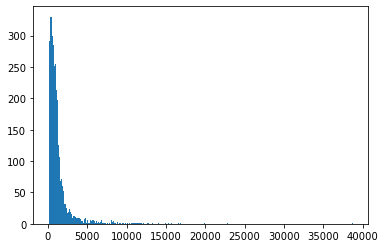

In [32]:
plt.hist(info_df['len'], 300)
plt.show()

In [4]:
# save weights
weights_filename = "weights.txt"
load_weights = True

if not load_weights:
    pickle.dump([wM,wD,wT], open(BASE_PATH+weights_filename,'wb'))
    print('Saved weights to file')
else:
    weights = pickle.load(open(BASE_PATH+weights_filename, 'rb'))
    print('Loaded weights from file')

Loaded weights from file


In [5]:
print(weights[0])

0     0.072372
1    -0.237594
2     0.127736
3    -0.741152
4    -0.054718
        ...   
59   -0.219222
60    0.103461
61    0.319058
62    0.569568
63   -0.532635
Length: 64, dtype: float64


In [5]:
print(x1_df.shape)
print(x3_np.shape)
print(x4_np.shape)

(3360, 64)
(2473, 3712)
(53846, 3712)


In [6]:
# Codon Linear Discriminant -- Normalize (Euclidean norm)

'''
norm = X / X.norm

A = (nx64)
b = (64xn)
x1_norm = (nx64)
'''

# https://stackoverflow.com/questions/18524112/norm-along-row-in-pandas
A = x1_df
b = pd.DataFrame(np.linalg.norm(A.values,axis=1)).transpose()
x1_norm = (A.transpose().div(b.iloc[0])).transpose().round(4)
check_nan = x1_norm.isnull().values.any()
print(f"NaNs present in monocodon data: {check_nan}")

A = x2_df 
b = pd.DataFrame(np.linalg.norm(A.values,axis=1)).transpose()
x2_norm = (A.transpose().div(b.iloc[0])).transpose().round(4)
check_nan = x2_norm.isnull().values.any()
print(f"NaNs present in dicodon data: {check_nan}")

y = info_df['y']

NaNs present in monocodon data: False
NaNs present in dicodon data: False


In [7]:
# TIS Linear Discriminant 

# convert to float32 to reduce matrix multiplication calculation time
# https://www.benjaminjohnston.com.au/matmul
X_TIS = np.concatenate((x3_np,x4_np), axis=0).astype(np.float32)

pos_y = [1]*len(x3_np)
neg_y = [-1]*len(x4_np)

y_TIS = pos_y + neg_y

print(len(X_TIS), len(y_TIS))

56319 56319


In [12]:
# Find weights
if not load_weights:
    lM = 1
    XM = x1_norm.transpose()
    IM = np.identity(XM.shape[0])
    wM = np.linalg.inv(XM@XM.transpose() + lM*IM) @ XM@y

    lD = 1
    XD = x2_norm.transpose()
    ID = np.identity(XD.shape[0])
    wD = np.linalg.inv(XD@XD.transpose() + lD*ID) @ XD@y

    lT = 1
    XT = X_TIS.transpose()
    IT = np.identity(XT.shape[0])
    wT = np.linalg.inv(XT@XT.transpose() + lT*IT) @ XT@y_TIS
else:
    XM = x1_norm.transpose()
    wM = weights[0]
    XD = x2_norm.transpose()    
    wD = weights[1]
    XT = X_TIS.transpose()
    wT = weights[2]

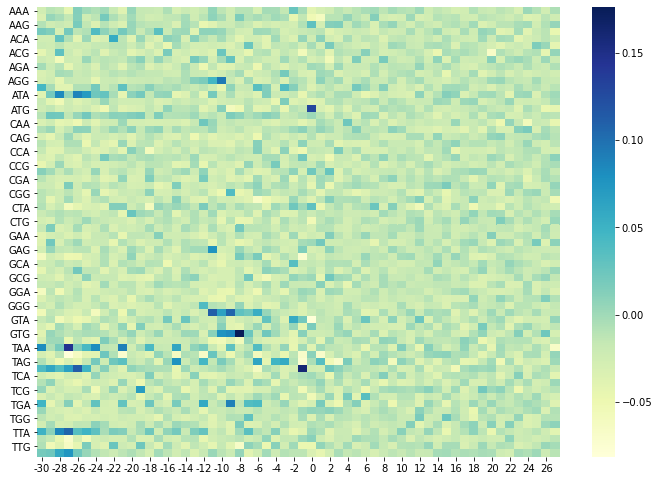

In [60]:
# visualize TIS patterns (up and downstream regions)
import seaborn as sns
import matplotlib.pyplot as plt

def __permutations_with_replacement(n):
    for i in itertools.product(("A", "C", "G", "T"), repeat=n):
        yield i

def __populate_codon_idx_dict(nbases=3):
    codon_idx_dict = {}
    for i in __permutations_with_replacement(nbases):
        codon_idx_dict["".join(i)] = 0
    return codon_idx_dict

w = wT.reshape(58,64).transpose()

y_axis_labels = __populate_codon_idx_dict().keys() 
x_axis_labels = [i for i in range(-30,28)]
df = pd.DataFrame(w, columns=x_axis_labels, index=y_axis_labels)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, cmap="YlGnBu")

In [9]:
# TIS Gaussian Distribution
import statistics as st

s = [x4_np@wT, x3_np@wT]
print(s[0].shape, s[1].shape)

label = [-1, 1]
pi = [round(len(neg_y)/(len(y_TIS)),4), round(len(pos_y)/(len(y_TIS)),4)]
mu = [round(st.mean(s[0]),4) , round(st.mean(s[1]),4)]
si = [round(st.stdev(s[0]),4), round(st.stdev(s[1]),4)]

print(pi)
print(mu)
print(si)

# likelihood - p(s|mu,si)
CONST = 1/np.sqrt(2*np.pi)
p_like = [(CONST/si[0])*np.exp(-(s[0] - mu[0])**2/(2*si[0]**2)),
         (CONST/si[1])*np.exp(-(s[1] - mu[1])**2/(2*si[1]**2))]

print(p_like[0].shape, p_like[1].shape)

# marginal density - p(s)
p_marg = sum(pi[0]*p_like[0]) + sum(pi[1]*p_like[1])
print(p_marg)

(53846,) (2473,)
[0.9561, 0.0439]
[-0.9288, -0.5509]
[0.1483, 0.327]
(53846,) (2473,)
100023.08962271205


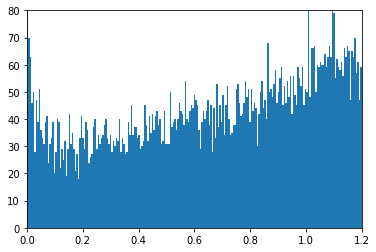

In [67]:
import matplotlib.pyplot as plt

plt.hist(p_s_minus, 500)
plt.axis([0.0, 1.2, 0, 80])
plt.show()

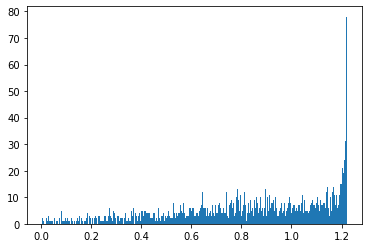

In [66]:
plt.hist(p_s_plus, 500)
plt.show()

In [13]:
l_max = 700

'''
x1 = monocodon wM * XM
x2 = dicodon wD * XD
x3 = positive TIS
x4 = negative TIS
x5 = complete
x6 = incomplete
x7 = GC content
'''

x1 = wM@XM # 3360 x 64
x2 = wD@XD # 3360 x 4096
x3 = (pi[1]*p_like[1])/p_marg #2473  x 3712
x4 = (pi[0]*p_like[0])/p_marg #53846 x 3712
x5 = None
x6 = None
x7 = x7_df # 3360x1